# 2. Introduction to Machine Learning in Python with Scikit-learn
![LISA logo](https://raw.githubusercontent.com/wshand/Python-Data-Science-Workshop/master/assets/LISA_logo_medium.jpg)

This notebook introduces some basic machine learning methods and how to implement them using the scikit-learn library.

# Table of contents
* [Introduction](#introduction)
* [Support vector machines](#svm)
* [Normalizing data](#normalization)
* [Scikit-learn pipelines](#pipelines)
* [Principal components analysis](#pca)
* [Cross-validation and grid search](#cross-validation)
* [Additional references](#additional-references)

# Introduction <a id="introduction"></a>
In recent years, Python has become a popular programming language for machine learning for a few reasons:

* Python is a high-level language, and fairly easy to learn
* It's relatively easy to integrate with low-level languages like C and Fortran, which can make well-written Python code run extremely quickly.
* Python already had a lot of great libraries for data visualization and manipulation, like pandas and matplotlib

Most cutting-edge, high-performance machine learning libraries have a Python interface. In this workshop, we're going to talk about one such library, [scikit-learn](https://scikit-learn.org). Scikit-learn is a toolbox with dozens upon dozens of the most popular algorithms for tasks like classification, regression, clustering, and dimensionality reduction. In addition, it contains utilities for cleaning up data and preparing it for machine learning.

We're going to use the [Labeled Faces in the Wild (LFW) dataset](http://vis-www.cs.umass.edu/lfw/) to demonstrate how to use scikit-learn. The LFW dataset includes about 1,300 grayscale images of seven individuals. Run the code cell below to download the data and show a few of the images in the dataset.

Number of faces: 1288
Number of unique people: 7
Height of every image: 37 pixels
Width of every image: 28 pixels


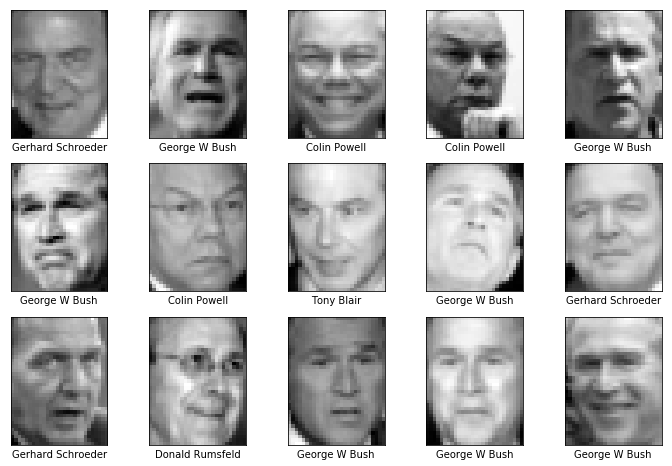

In [1]:
%matplotlib inline

import itertools
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats             import multivariate_normal
from sklearn.decomposition   import PCA
from sklearn.preprocessing   import StandardScaler
from sklearn.svm             import SVC
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.datasets        import fetch_lfw_people

########## Helper functions
def square_axes(ax, data, expansion_factor=1.05):
    # Change limits of plot axes to center on the input dataset, and to put the
    # x-axis and y-axis on the same scale
    m        = np.mean(data)
    max_dist = max([np.linalg.norm(u-m) for u in data]) * expansion_factor
    lims     = [m-max_dist, m+max_dist]
    try:    ax.set_xlim(lims); ax.set_ylim(lims)
    except: ax.xlim(lims); ax.ylim(lims)
##########################

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.3)

# Get the number of images, as well as the height and width (in pixels) of each image
n_samples, h, w = lfw_people.images.shape

# Separate data into images and labels
X = lfw_people.data
y = lfw_people.target

print("Number of faces:", n_samples)
print("Number of unique people:", len(lfw_people.target_names))
print("Height of every image:", h, "pixels")
print("Width of every image:", w, "pixels")

# Plot some randomly selected faces
n_images_x, n_images_y = (5,3)
fig, axes = plt.subplots(n_images_y, n_images_x, figsize=(12,8))
rand_choices = np.random.choice(n_samples, size=n_images_x * n_images_y)

for (kk, (ii, jj)) in zip(rand_choices, itertools.product(range(n_images_y), range(n_images_x))):
    face = lfw_people.images[kk]
    name = lfw_people.target_names[y[kk]]
    axes[ii,jj].imshow(face, cmap='gray')
    axes[ii,jj].set_xticks([])
    axes[ii,jj].set_yticks([])
    axes[ii,jj].set_xlabel(name)

plt.show()

# Support vector machines
In this notebook, I'm going to show you how to use machine learning to recognize faces of people from this dataset. By the end, you'll have a full-fledged machine learning system that can automatically classify these images by who they feature.

Our first step will be to understand [support vector machines](https://en.wikipedia.org/wiki/Support_vector_machine) (SVMs). Support vector machines are a powerful tool for classifying data, and have the benefit of being fairly simple to use. *Deeper description of SVMs*

*Scikit-learn interface* -- `BaseEstimator`, `TransformerMixin`, etc.

Machine learning in scikit-learn generally consists of three steps:

1. Create an object that corresponds to the algorithm you want to use. Since we want to do classification with support vector machines, we're going to create an `SVC` (support vector classifier) object.
2. Call the object's `fit` function.
3. Now our learner is trained. For our support vector classifier, we're can now use its `predict` function to classify images.

In [ ]:
from sklearn.svm import SVC # SVC = support vector classifier

# 1. Create an SVC object. Give it the parameters we want to use for the classifier,
#    e.g. the kind of kernel function to use, the value of the parameter C, etc.
svc = SVC(C=1.0, gamma='scale', kernel='rbf')

# 2. Call the fit function. We're only going to use 500 of the data points to make
#    training a little shorter.
svc.fit(X[:500],y[:500])

# 3. Make predictions with our newly trained SVC
predictions = svc.predict(X)

Classifiers like `SVC` offer a `score` function that tell you how good your machine learning system is.

In [ ]:
print("Accuracy on training set: %.4f" % svc.score(X[:500], y[:500]))
print("Accuracy on remaining data: %.4f" % svc.score(X[500:], y[500:]))

When I ran this code I got the following output:

> ```
Accuracy on training set: 1.0000
Accuracy on remaining data: 0.4124
```

The first line indicates that my support vector machine accurately identifies the person in the 500 images I trained it on (the *training data*) 100% of the time. However, on the remaining images (the *testing data*), I only got 41.24% accuracy. In other words, the SVM gets almost 60% better accuracy on the images it was trained on than the images it wasn't trained on.

That's not very good. In the real world, we want our machine learning systems to be able to deal with data they weren't trained on. For instance, suppose we wanted to teach a computer to play chess. Since there are over $10^{120}$ possible games of chess, we can only train our computer on a very small fraction of them. However, we still have to ensure that our machine learning system does well when playing positions it's never seen before.

In the remainder of this notebook, we're going to look at how we can improve the accuracy of our SVM.

# Normalizing data <a id="normalization"></a>
[Normalization wiki article](https://en.wikipedia.org/wiki/Normalization_(statistics))

Different features of datasets exist on a variety of scales. For example, consider the following data points (from the California housing dataset):

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

*California housing dataset table*

| (Statistic) | Median income | House age (years) | Average rooms | Population | Price |
| --- | --- | --- | --- | --- | --- |
| **Min**                | 0.5  | 1     | 0 | 0 | 0 | 0 |
| **Max**                | 15.9 | 52    | 0 | 0 | 0 | 0 |
| **Median**             | 3.5  | 29    | 0 | 0 | 0 | 0 |
| **Average**            | 3.9  | 28.6  | 0 | 0 | 0 | 0 |
| **Standard deviation** | 1.9  | 12.6  | 0 | 0 | 0 | 0 |

The house ages range from 1 - 52 years; the populations from 3 - 35,682 people; and the prices from \\$??? - \\$???.

In [17]:
from sklearn.preprocessing import StandardScaler

X_normalized = StandardScaler().fit_transform(X)

# Try training and scoring the support vector machine on the normalized dataset
svc = SVC(C=1.0, gamma='scale', kernel='rbf')
svc.fit(X_normalized[:500],y[:500])

print("Accuracy on training set: %.4f" % svc.score(X_normalized[:500], y[:500]))
print("Accuracy on remaining data: %.4f" % svc.score(X_normalized[500:], y[500:]))

Accuracy on training set: 0.9240
Accuracy on remaining data: 0.6574


When I ran this code, I got the following results:

> ```
Accuracy on training set: 0.9240
Accuracy on remaining data: 0.6574```

That's a pretty remarkable improvement! Just by normalizing the data before training our support vector classifier, our classifier went from $41\%$ accuracy in classifying the data it wasn't trained on to about $66\%$ accuracy.

# Putting pieces together: Pipelines in scikit-learn <a id="pipelines"></a>
Notice that in the previous section, training our support vector machine consisted of two steps:

1. Normalizing the data with a `StandardScaler`
2. Feeding the normalized data to the `SVC` object to train our learner

As we add more and more steps, keeping track of the overhead for each step can become a nuisance. To help alleviate this problem, scikit-learn provides the [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object. To build a `Pipeline`, we must provide a list of the steps in our machine learning system as well as a name for those steps. For instance, in the code cell below I've named the `StandardScaler` step `'scaler'`, and the support vector classification step `'classify'`:

In [15]:
learner = Pipeline([
    ('scaler', StandardScaler()),
    ('classify', SVC(C=1.0, gamma='scale', kernel='rbf'))
])

learner.fit(X[:500], y[:500])

print("Accuracy on training set: %.4f" % learner.score(X[:500], y[:500]))
print("Accuracy on remaining data: %.4f" % learner.score(X[500:], y[500:]))

Accuracy on training set: 0.9240
Accuracy on remaining data: 0.6624


# Principal components analysis <a id="pca"></a>
Our images are 37 pixels tall by 28 pixels wide, or 1,036 pixels total. This means that each data point we are using to train our support vector machine is 1,036-dimensional, which is fairly large. By reducing this dimension via *dimensionality reduction*, we are able to train our SVM much faster.

One common way of performing dimensionality reduction is via [*principal components analysis*](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA). PCA finds the "most important" parts of the data, known as the *principal components*. It keeps those parts and throws the rest of the data away.

As a demonstration, try out the code cell below. In the code cell, we create some random data distributed according to a multivariate normal distribution. Then we generate some plots that show how the process of PCA works.

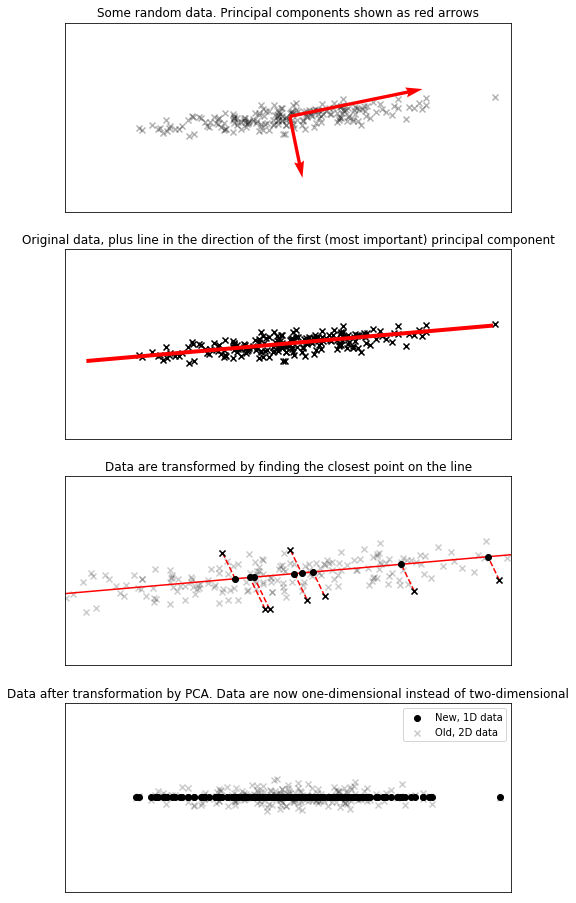

In [9]:
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA

# Create some random data
rdata = multivariate_normal.rvs(cov=[[6, 1], [1, 0.5]], size=200)

# Fit PCA to the data. Normally we would use n_components=1 to only keep the first principal component,
# but here we'll use n_components=2 for purpose of demonstration
pca = PCA(n_components=2)
pca.fit(rdata)

# Project data onto the first principal component
line              = np.max(np.abs(rdata)) * np.array([-pca.components_[0], pca.components_[0]])
projected_lengths = rdata.dot(pca.components_[0])
projections       = np.array([l * pca.components_[0] for l in projected_lengths])

fig, axes = plt.subplots(4, 1, figsize=(8,16))

# __Plot 0__: Plot data and overlay principal components
axes[0].scatter(rdata[:,0], rdata[:,1], marker='x', color='k', zorder=0, alpha=0.3)
axes[0].quiver(0, 0, pca.components_[:,0] * np.sqrt(pca.singular_values_), 
           pca.components_[:,1] * np.sqrt(pca.singular_values_), color=['r', 'r'], zorder=1, scale=20)
axes[0].set_title("Some random data. Principal components shown as red arrows")

# __Plot 1__: Plot data and line through first principal component in first subplot
axes[1].scatter(rdata[:,0], rdata[:,1], marker='x', color='k')
axes[1].plot(line[:,0], line[:,1], color='red', linewidth=4)
axes[1].set_title("Original data, plus line in the direction of the first (most important) principal component")

# __Plot 2__: Show the effect of the projection on the middle subplot using a few of the points.
# Points are chosen randomly from those with the highest residual norm.
c = sorted(range(rdata.shape[0]), key=lambda ii: np.linalg.norm(rdata[ii]-projections[ii]))[-8:]
axes[2].scatter(rdata[:,0], rdata[:,1], marker='x', color='k', alpha=0.2, zorder=0)
axes[2].plot(line[:,0], line[:,1], color='red', zorder=1)
axes[2].scatter(projections[c,0], projections[c,1], color='k', zorder=2)
axes[2].scatter(rdata[c,0], rdata[c,1], marker='x', color='k', zorder=2)
axes[2].set_title("Data are transformed by finding the closest point on the line")
for (orig,proj) in zip(rdata[c], projections[c]):
    axes[2].plot([orig[0], proj[0]], [orig[1], proj[1]], 'r--', zorder=1)
    
# __Plot 3__: Plot data projected onto line in the last subplot
axes[3].scatter(projected_lengths, [0 for l in projected_lengths], marker='o', 
                color='k', zorder=1, label='New, 1D data')
axes[3].scatter(projected_lengths, rdata.dot([pca.components_[0,1] / pca.components_[0,0], -1]), 
                alpha=0.2, marker='x', color='k', zorder=1, label='Old, 2D data')
axes[3].set_title("Data after transformation by PCA. Data are now one-dimensional instead of two-dimensional")
axes[3].legend()

# Set axis ticks and axis limits for each plot
for (ax,dat) in zip(axes, (rdata, rdata, rdata[c], rdata)):
    ax.set_xticks([]); ax.set_yticks([])
    square_axes(ax,dat)

plt.show()

To run PCA in scikit-learn, we have to use the `PCA` class from `sklearn.decomposition`.

```python
from sklearn.decomposition import PCA

pca = PCA(n_components = N) # N = number of components you want
pca.fit(data)               # Finds the top N principal components

# Now call pca.transform to reduce the dimension of the data
```

To get a more tangible idea of what PCA does, we can look at some [eigenfaces](https://en.wikipedia.org/wiki/Eigenface) from the LFW dataset.

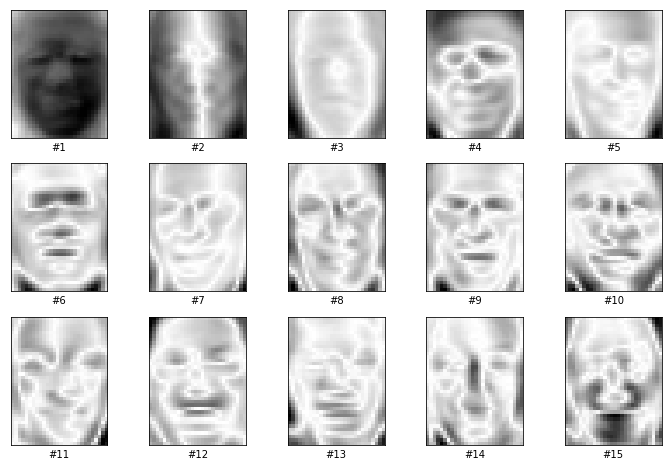

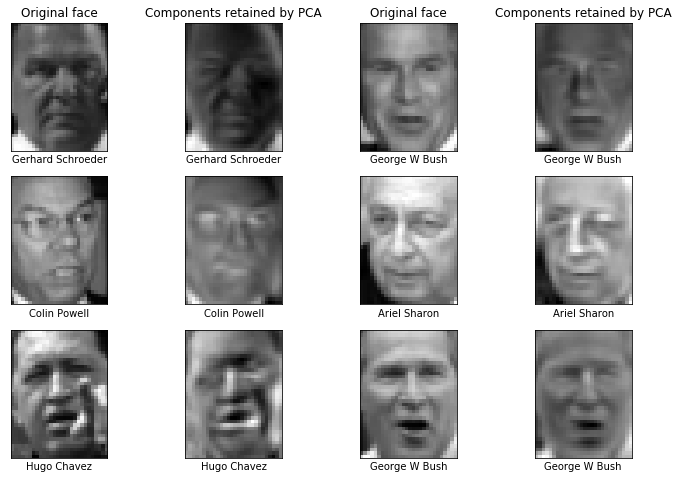

In [8]:
# Change n_components to change the number of principal components computed by PCA.
#     Higher n_components -> better retention of original image but higher dimension
#     Lower n_components  -> worse retention of original image but lower dimension
pca = PCA(n_components=100).fit(X)

fig, axes = plt.subplots(n_images_y, n_images_x, figsize=(12,8))
for (kk, (ii,jj)) in enumerate(itertools.product(range(n_images_y), range(n_images_x))):
    eigenface = pca.components_[kk].reshape((h,w))
    eigenface = -np.abs(eigenface)
    axes[ii,jj].imshow(eigenface, cmap='gray')
    axes[ii,jj].set_xticks([])
    axes[ii,jj].set_yticks([])
    axes[ii,jj].set_xlabel("#" + str(kk + 1))

plt.show()

# Project a few randomly chosen faces onto the principal components
rand_choices = np.random.choice(X.shape[0], size=6) # 2 faces/row
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for (ii,axrow) in enumerate(axes):
    for (c,col) in zip(rand_choices[2*ii:2*(ii+1)],range(2)):
        proj = pca.transform(X[c].reshape((1,h*w))).dot(pca.components_)
        for (face,ax) in zip((X[c],proj), (axrow[2*col], axrow[2*col+1])):
            ax.imshow(face.reshape((h,w)), cmap='gray')
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_xlabel(lfw_people.target_names[y[c]])

for ax in (axes[0,0], axes[0,2]): ax.set_title("Original face")
for ax in (axes[0,1], axes[0,3]): ax.set_title("Components retained by PCA")

plt.show()

# Cross-validation and grid search <a id="cross-validation"></a>
One of the most important parts of all machine learning algorithms is picking the best possible hyperparameters. The difference between a well-chosen and poorly-chosen hyperparameter can be staggering; *compare accuracy of methods after choosing C correctly*

In order to improve our accuracy, we're going to try to find the best value of the hyperparameter $C$ that the support vector machine uses. Recall that $C$ *describe what C does*.

One way for us to choose $C$ would be to train our learner on all of our data with a few different values of $C$. Then we go back over the data and see how accurate our learner is, and choose the value of $C$ that gave us a learner with the best accuracy. A big issue with this approach is that most machine learning methods are very good at classifying data they *are* trained with, and much worse at classifying data they *aren't* trained with. So if we choose our hyperparameter in this way, we could get a learner that does fantastic on the training set and horrendously when used in the real world.

*Overfitting diagram*

The easiest way to choose $C$ is to split our data into a *training set* and a *test set*. The training set is the part of the data that our machine learning algorithm actually learns from. Once the learner is trained, we score it on the test set, which gives a better estimate of how good our learner really is. After picking a few values of $C$ and training our learner, we use the value that got the best score on the test set.

In [ ]:
from sklearn.model_selection import train_test_split

learner = Pipeline([
    ('scaler', StandardScaler()),
    ('dim-reduce', PCA(n_components=250)),
    ('classify', SVC(C=1.0, gamma='scale', kernel='rbf'))
])

# Split into training and tests sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Fit the learner and score on the training and testing sets
learner.fit(X_train, y_train)
print("Score on training set: %.4f" % learner.score(X_train, y_train))
print("Score on testing set: %.4f" % learner.score(X_test, y_test))

One problem with this approach is that as we keep tuning parameters, we start biasing ourselves towards the test set. In the example above, we search for the hyperparameter $C$ by choosing which value of $C$ does best on the test set. But if we keep fine-tuning $C$, we could run into a situation where we've found a hyperparameter that happens to do well on the training and test sets, but doesn't do well outside of these datasets. 

With just one hyperparameter, this isn't much of a problem. It's unlikely that a choice of $C$ that does well on the training and test sets will do poorly on other data. But for machine learning methods that require dozens or even hundreds of hyperparameters (such as neural networks), it's easy to overfit because you only used a single test set. 

In [ ]:
from sklearn.model_selection import KFold

learner = Pipeline([
    ('scaler', StandardScaler()),
    ('dim-reduce', PCA(n_components=100)),
    ('classify', SVC(C=1.0, gamma='scale'))
])

kf = KFold(n_splits=5)
scores = []
for (train, valid) in kf.split(X_train):
    learner.fit(X_train[train], y_train[train])
    scores.append(learner.score(X_train[valid], y_train[valid]))

print("Average score on validation sets: %.4f" % np.mean(scores))

*Grid search*

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'classify__C': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]}
grid_search = GridSearchCV(learner, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Additional References <a id="additional-references"></a>
* O'Reilly books:
* Since the boom of interest in deep learning over the past decade, multiple frameworks for writing neural networks have been developed:
  * [TensorFlow](https://www.tensorflow.org)
  * [PyTorch](https://www.pytorch.org)
  * [Keras](), which isn't a standalone library but rather a high-level user interface that simplifies the process of writing neural nets in TensorFlow and PyTorch.